# Self Supervised Learning and Linear Probing on CIFAR10

In this notebook, we use the MOCOV3 method to train a model in a self-supervised learning (SSL) fashion, and evaluate the model by the classification accuracy of linear probing. We use the `solo_learn` library ({cite}`sololearn`, alternatives: `VISSL`, `lightly`) which has a good coverage of recent self-supervised learning algorithms.

## Install

In [ ]:
# Pip-installing solo_learn 1.0.2 requires torch 1.9 and uninstalls newer verions.
#     This seems unnecessary and causes other problems.
# !pip install solo_learn==1.0.2 
#
# Instead, install directly from the repo:
# https://github.com/vturrisi/solo-learn/commit/601920489cc464e77835be6c1e5b883b98293c20
!pip install git+https://github.com/vturrisi/solo-learn.git@601920489cc464e77835be6c1e5b883b98293c20

## Listing SSL Methods

Here is a list of SSL methods provided by `solo-learn`:

In [17]:
# List of SSL methods:
import solo.methods
[x for x in solo.methods.__all__ if not x.startswith("Base")]

['BarlowTwins',
 'BYOL',
 'DeepClusterV2',
 'DINO',
 'MAE',
 'LinearModel',
 'MoCoV2Plus',
 'MoCoV3',
 'NNBYOL',
 'NNCLR',
 'NNSiam',
 'ReSSL',
 'SimCLR',
 'SimSiam',
 'SupCon',
 'SwAV',
 'VIbCReg',
 'VICReg',
 'WMSE']

## MOCOV3

In [2]:
from solo.methods import BarlowTwins, MoCoV3
from solo.utils.checkpointer import Checkpointer

from solo.data.pretrain_dataloader import (
    prepare_dataloader,
    prepare_datasets,
    prepare_n_crop_transform,
    prepare_transform,
)

ssl_method_class = MoCoV3



A self supervised learning `Method` in `solo-learn` is a pytorch `LightningModule`. To see this, let's print out the method resolution order (MRO):

In [3]:
ssl_method_class.mro()

[solo.methods.mocov3.MoCoV3,
 solo.methods.base.BaseMomentumMethod,
 solo.methods.base.BaseMethod,
 pytorch_lightning.core.lightning.LightningModule,
 pytorch_lightning.core.mixins.device_dtype_mixin.DeviceDtypeModuleMixin,
 pytorch_lightning.core.mixins.hparams_mixin.HyperparametersMixin,
 pytorch_lightning.core.saving.ModelIO,
 pytorch_lightning.core.hooks.ModelHooks,
 pytorch_lightning.core.hooks.DataHooks,
 pytorch_lightning.core.hooks.CheckpointHooks,
 torch.nn.modules.module.Module,
 object]

In [4]:
# common parameters for all methods
# some parameters for extra functionally are missing, but don't mind this for now.
base_kwargs = {
    "backbone": "resnet18",
    "num_classes": 10,
    "cifar": True,
    "zero_init_residual": True,
    "max_epochs": 10,
    "optimizer": "sgd",
    "lars": True,
    "lr": 0.01,
    "gpus": "0",
    "grad_clip_lars": True,
    "weight_decay": 0.00001,
    "classifier_lr": 0.5,
    "exclude_bias_n_norm_lars": True,
    "accumulate_grad_batches": 1,
    "extra_optimizer_args": {"momentum": 0.9},
    "scheduler": "warmup_cosine",
    "min_lr": 0.0,
    "warmup_start_lr": 0.003,
    "warmup_epochs": 2,
    "num_crops_per_aug": [2, 0],
    "num_large_crops": 2,
    "num_small_crops": 0,
    "eta_lars": 0.02,
    "lr_decay_steps": None,
    "dali_device": "gpu",
    "batch_size": 256,
    "num_workers": 4,
    "data_dir": "/data/datasets",
    "train_dir": "cifar10/train",
    "val_dir": "cifar10/val",
    "dataset": "cifar10",
    "name": "barlow-cifar10",
}

# barlow specific parameters
# method_kwargs = {
#     "proj_hidden_dim": 2048,
#     "proj_output_dim": 2048,
#     "lamb": 5e-3,
#     "scale_loss": 0.025,
#     "backbone_args": {"cifar": True, "zero_init_residual": False},
# }

# mocov3 specific params
method_kwargs = {
    "exclude_bias_n_norm_lars": True,
    "lr": 0.3,
    "classifier_lr": 0.3,
    "warmup_start_lr": 3e-5,
    "weight_decay": 1e-6,
    "min_scale": 0.2,
    "crop_size": 32,
    "proj_hidden_dim": 4096,
    "proj_output_dim": 256,
    "pred_hidden_dim": 4096,
    "temperature": 0.2,
    "base_tau_momentum": 0.99,
    "final_tau_momentum": 1.0,
    "momentum_classifier": False,
    "unique_augs": 2,
    "backbone_args": {"cifar": True, "zero_init_residual": False},
}


kwargs = {**base_kwargs, **method_kwargs}

model = ssl_method_class(**kwargs)

## Model architecture

Notice the classifier and projector sub-modules.

In [5]:
model

MoCoV3(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (con

## Dataset

In [6]:
# we first prepare our single transformation pipeline
transform_kwargs = {
    "brightness": 0.4,
    "contrast": 0.4,
    "saturation": 0.4,
    "hue": 0.1,
    "gaussian_prob": 0.0,
    "solarization_prob": 0.0,
    "color_jitter_prob": 0.8,
    "gray_scale_prob": 0.2,
    "min_scale": 0.2,
    "max_scale": 1.0,
}
transform = [prepare_transform("cifar10", **transform_kwargs)]

# then, we wrap the pipepline using this utility function
# to make it produce an arbitrary number of crops
transform = prepare_n_crop_transform(transform, num_crops_per_aug=[2])

# finally, we produce the Dataset/Dataloader classes
train_dataset = prepare_datasets(
    dataset="cifar10",
    transform=transform,
    no_labels=False,
)
train_loader = prepare_dataloader(
    train_dataset, batch_size=base_kwargs["batch_size"], num_workers=base_kwargs["num_workers"]
)

Files already downloaded and verified


In [7]:
one_example = train_dataset[0]
# (idx, [image_tensor1, image_tensor2, integer class idx])
one_example

(0,
 [tensor([[[-0.4653, -0.4653, -0.4653,  ..., -0.2430, -0.2430, -0.2907],
           [-0.4018, -0.4177, -0.4335,  ..., -0.3542, -0.4177, -0.5129],
           [-0.2907, -0.3383, -0.3542,  ..., -0.4653, -0.5764, -0.7193],
           ...,
           [-0.3859, -0.3542, -0.2589,  ..., -0.2589, -0.0208,  0.3920],
           [-0.2271, -0.2748, -0.2748,  ..., -0.2748,  0.0110,  0.5349],
           [ 0.0110, -0.1160, -0.1954,  ..., -0.4653, -0.2430,  0.3603]],
  
          [[-1.2395, -1.2234, -1.2072,  ..., -1.0301, -1.0301, -1.0301],
           [-1.2072, -1.2072, -1.2072,  ..., -1.1106, -1.1589, -1.2072],
           [-1.1428, -1.1428, -1.1428,  ..., -1.1750, -1.2556, -1.3361],
           ...,
           [-1.1911, -1.1589, -1.0784,  ..., -1.0623, -0.8690, -0.4825],
           [-1.1428, -1.2072, -1.1428,  ..., -0.9979, -0.7563, -0.2732],
           [-1.0140, -1.0784, -1.0945,  ..., -1.0301, -0.8690, -0.3537]],
  
          [[-0.9573, -0.9723, -0.9573,  ..., -0.7924, -0.7924, -0.7924],
       

## Set up Logging and Callbacks

In [8]:
from pytorch_lightning.callbacks import LearningRateMonitor

use_wandb_logger = False

if use_wandb_logger:
  from pytorch_lightning.loggers import WandbLogger

  logger = WandbLogger(
      name=f"{ssl_method_class.__name__.lower()}-cifar10",  # name of the experiment
      project="self-supervised",  # name of the wandb project
      entity=None,
      offline=False,
  )
  logger.experiment.config.update(kwargs)
  logger.watch(model, log="gradients", log_freq=100)
else:
  from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger

  # logger = TensorBoardLogger("tb_logs", name="self_supervised")
  logger = CSVLogger("csv_logs", name="self_supervised")

callbacks = []

# automatically log our learning rate
lr_monitor = LearningRateMonitor(logging_interval="epoch")
callbacks.append(lr_monitor)

## Training

In [ ]:
from solo.data.classification_dataloader import prepare_data as prepare_data_classification

# we will also create a validation dataloader to automatically
# check how well our models is doing in an online fashion.
_, val_loader = prepare_data_classification(
    "cifar10",
    batch_size=base_kwargs["batch_size"],
    num_workers=base_kwargs["num_workers"],
)

In [ ]:
from pytorch_lightning import Trainer
from argparse import Namespace
from pytorch_lightning.plugins import DDPPlugin



args = Namespace(**kwargs)

trainer = Trainer.from_argparse_args(
    args,
    logger=logger,
    callbacks=callbacks,
    checkpoint_callback=False,
    terminate_on_nan=True,
    accelerator="gpu",
    # If you like to use the DDP accelerater, don't do it in the jupyter notebook, as
    #   the following error would occur:
    # MisconfigurationException: `Trainer(strategy='ddp')` or `Trainer(accelerator='ddp')` is not compatible with an interactive environment. Run your code as a script, or choose one of the compatible strategies: Trainer(strategy=None|dp|tpu_spawn). In case you are spawning processes yourself, make sure to include the Trainer creation inside the worker function.
    # plugins=DDPPlugin(find_unused_parameters=True),
    # accelerator="ddp",
)

trainer.fit(model, train_loader, val_loader)

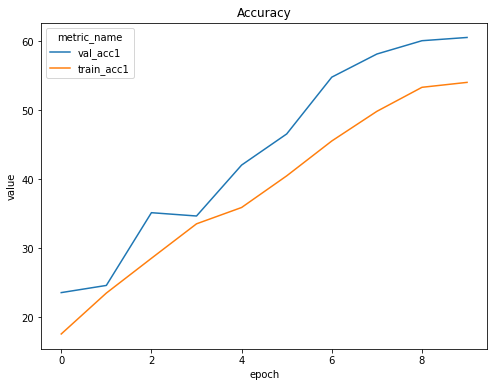

In [14]:
if not use_wandb_logger:
  import os
  import pandas as pd
  from matplotlib import pyplot as plt
  import seaborn as sns

  versions = [int(d.replace("version_", "")) for d in os.listdir("csv_logs/self_supervised/") if "version" in d]
  latest_version = versions[-1]
  metrics = pd.read_csv(f"csv_logs/self_supervised/version_{latest_version}/metrics.csv")
  plt.figure(figsize=(8, 6))
  df = metrics[["epoch", "val_acc1"]].drop_duplicates().assign(metric_name="val_acc1").rename(columns={"val_acc1": "value"}).dropna(how="any")
  # print(df)
  df = pd.concat([df, metrics[["epoch", "train_acc1_epoch"]].drop_duplicates().rename(columns={"train_acc1_epoch": "value"}).assign(metric_name="train_acc1").dropna(how="any")])
  # print(df)
  sns.lineplot(data=df, x="epoch", y="value", hue="metric_name").set(title="Accuracy")
else:
  trainer.logger.experiment.finalize("success")